# Review Sentiment Analysis
The dataset and information about it can be found in the following link:
https://www.kaggle.com/datasets/shivkumarganesh/bumble-dating-app-google-play-store-review.

### Goal: Maximize models ability to identify negative reviews (true negative rate/specificity) to easily find user problems to be able to increase user satisfaction.

In [131]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tcr
%matplotlib inline
import seaborn as sns
import emoji
import string
import nltk
nltk.download('stopwords') #needed to download the stopwords first before importing
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from fast_ml.model_development import train_valid_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
import time
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')

# import data
raw_reviews = pd.read_csv('C:/Users/xsoni/Desktop/bumble_google_play_reviews.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xsoni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data exploration

In [96]:
pd.set_option('max_colwidth', 30)
raw_reviews # content seems to mean "comment", lots of columns that we wont have any use for

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,9654a0b5-4d0b-4c19-bf8b-3b...,Richard,https://play-lh.googleuser...,Live it My world,5,0,5.295.1,2022-11-20 01:46:09,NaN,NaN
1,a064f586-826d-42a5-83bc-4b...,Leigh Kilday,https://play-lh.googleuser...,Mediocre,3,0,5.290.1,2022-11-20 01:38:37,We're sorry you didn't enj...,2022-11-20 02:49:17
2,17470213-3989-49c3-9fb4-55...,Luke Amrine,https://play-lh.googleuser...,You have to pay to see who...,3,0,5.295.1,2022-11-20 01:34:34,Your feedback is extremely...,2022-11-20 02:49:15
3,6e79691b-b07a-42a7-82db-7d...,David Carter,https://play-lh.googleuser...,You match with tons of peo...,2,0,NaN,2022-11-20 01:00:15,Hi David. On Bumble we emp...,2022-11-20 02:54:45
4,2d095733-347f-40aa-9df0-22...,Ana L Montoya,https://play-lh.googleuser...,perfect,5,0,5.296.1,2022-11-20 00:54:05,Thanks for letting us know...,2022-11-20 02:48:47
...,...,...,...,...,...,...,...,...,...,...
120312,61bc7cdc-3085-4631-ac95-d8...,A Google user,https://play-lh.googleuser...,Finally here!,5,54,1.0.1,2015-12-01 02:17:24,NaN,NaN
120313,24d07489-88ad-496a-80ce-8f...,A Google user,https://play-lh.googleuser...,Finally!,5,75,1.0.1,2015-12-01 02:09:05,NaN,NaN
120314,22a42d0d-7a12-400d-a2af-82...,A Google user,https://play-lh.googleuser...,"Finally, an app where wome...",4,2,1.0.1,2015-12-01 00:18:53,NaN,NaN
120315,2480a41f-8863-4948-9f83-7d...,A Google user,https://play-lh.googleuser...,At last we have Android ve...,5,60,1.0.0,2015-11-30 21:27:51,NaN,NaN


In [97]:
raw_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120317 entries, 0 to 120316
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              120317 non-null  object
 1   userName              120317 non-null  object
 2   userImage             120317 non-null  object
 3   content               120311 non-null  object
 4   score                 120317 non-null  int64 
 5   thumbsUpCount         120317 non-null  int64 
 6   reviewCreatedVersion  100735 non-null  object
 7   at                    120317 non-null  object
 8   replyContent          76165 non-null   object
 9   repliedAt             76165 non-null   object
dtypes: int64(2), object(8)
memory usage: 9.2+ MB


In [98]:
raw_reviews.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
reviewId,120317,120317,9654a0b5-4d0b-4c19-bf8b-3b...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userName,120317,59510,A Google user,58129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userImage,120317,62178,https://play-lh.googleuser...,58128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
content,120311,103824,Good,1364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,120317.0,NaN,NaN,NaN,2.770539,1.71886,1.0,1.0,2.0,5.0,5.0
thumbsUpCount,120317.0,NaN,NaN,NaN,2.756369,20.404614,0.0,0.0,0.0,1.0,1685.0
reviewCreatedVersion,100735,410,1.15.0,1645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
at,120317,120215,2019-04-23 10:40:29,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
replyContent,76165,40951,We're sorry you didn't enj...,2446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
repliedAt,76165,75645,2021-03-06 17:34:21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notes:
- We have choices here for what data we wish to use in our sentiment analysis of the reviews. We will keep only the content and score. One could also make use of the thumbsUpCount, replies and also keep the identity of the user to create a more complex understanding of the data. A nice way of carrying out the analysis would be to do the sentiment analysis per user, rather than per review. For simplicity we will however carry out the analysis per review.
- Almost all reviews have both a score and 'content' i.e a comment. We will remove the reviews without comments.

In [170]:
reviews = raw_reviews[raw_reviews['content'].isnull() == False] # Remove rows without comment
reviews = raw_reviews.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', \
                       'repliedAt'], axis = 1) # Drop all other columns than content and score

In [102]:
reviews

,content,score
0,Live it My world,5
1,Mediocre,3
2,You have to pay to see who...,3
3,You match with tons of peo...,2
4,perfect,5
...,...,...
120312,Finally here!,5
120313,Finally!,5
120314,"Finally, an app where wome...",4
120315,At last we have Android ve...,5


   score  counts
0      1   49794
1      2   11217
2      3   10217
3      4   14981
4      5   34108


<BarContainer object of 5 artists>

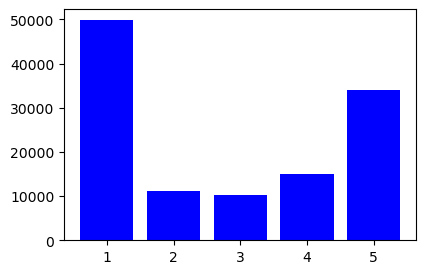

In [103]:
score_counts = reviews.groupby('score').size().to_frame().reset_index().rename(columns = {0: 'counts'})
print(score_counts)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.bar(score_counts.score, score_counts.counts, color = 'b')

There definitely seems to exist selection bias where those that feel strongly about the app are those that leave a review, hence why there are mostly 1's and 5's. 

Since our goal is to identify reviews which may contain useful information about how to increase user satisfaction we will transform scores to positive/negative. We let scores 1-3 correspond to negative and 4-5 to positive. The reason for letting 3 be negative is that, in my own experience, when I see a review with 3/5 it usually contains some information about something that the customer did not like.

  sentiment  counts
0  Negative   71228
1  Positive   49089


<BarContainer object of 2 artists>

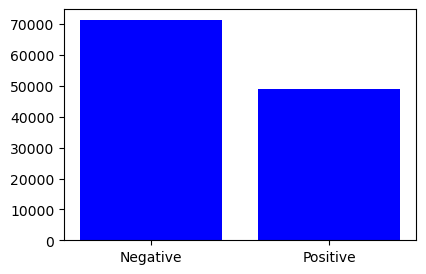

In [118]:
reviews['sentiment'] = reviews['score'].apply(lambda score: 'Negative' if score <= 3 else 'Positive')
sentiment_counts = reviews.groupby('sentiment').size().to_frame().reset_index().rename(columns = {0: 'counts'})
print(sentiment_counts)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.bar(sentiment_counts.sentiment, sentiment_counts.counts, color = 'b')

### We replace emoji's with text that the models will understand

In [135]:
pd.set_option('max_colwidth', 1000)
reviews.iloc[[48]] # example of row where emoji appears in content-string


,content,score,sentiment
48,"Guess what ruined bumble? Yep ""pronouns"" 🤪 . Because if it wasn't hard enough to find the opposite sex, now bumble has made it even harder. they don't have to tell you if their (male) or (female)‽ Yep ""them they"" is apparently a gender or some Rubish .. so now I have to match and find out if it's a male or female 👍... Imagine 2022 and we have to talk for a while before ""they"" ""them"" it cat dog or what ever they are this week, actually tells you their gender? You couldn't make this shite up ...",1,Negative


In [173]:
def remove_emoji(string):
    return emoji.demojize(string)

reviews['content']=reviews['content'].astype(str).apply(lambda content: emoji.demojize(content))

In [175]:
reviews.iloc[[48]] # Emojis are now turned into text that can be used by models

,content,score
48,"Guess what ruined bumble? Yep ""pronouns"" :zany_face: . Because if it wasn't hard enough to find the opposite sex, now bumble has made it even harder. they don't have to tell you if their (male) or (female)‽ Yep ""them they"" is apparently a gender or some Rubish .. so now I have to match and find out if it's a male or female :thumbs_up:... Imagine 2022 and we have to talk for a while before ""they"" ""them"" it cat dog or what ever they are this week, actually tells you their gender? You couldn't make this shite up ...",1


## Text Processing

# To-do:
- Text processing: punctuation, stop words, stemming, lower case, emojis, 
- Naive Bayes, Logistic Regression, Random Forest
- Feature engineering and hyperparameter tuning to optimize specificity

Notebooks that can be used to draw inspiration from:
- https://www.kaggle.com/code/rudyschn/how-users-get-stung-by-bumble
- https://github.com/amybirdee/Predicting_app_review_sentiment/blob/main/bumble_google_play_reviews.ipynb